In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np


# Load the dataset
df = pd.read_csv("WineQT.csv")  # Change filename if needed

# Display basic information
print(df.info())
print("\nFirst 5 rows:\n", df.head())

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Summary statistics
print("\nDataset Summary:\n", df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB
None

First 5 rows:
    fixed acidity  volatile acidity  citric acid  resid

<ipython-input-10-fdf4c3d1e300>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['quality'], palette='viridis')


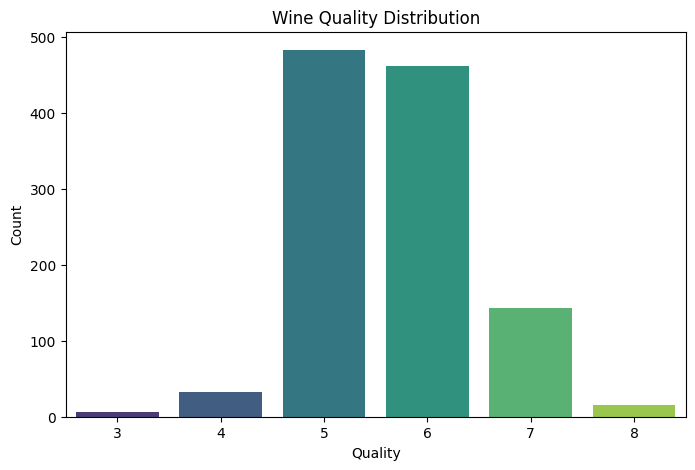

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Countplot for wine quality distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df['quality'], palette='viridis')
plt.title("Wine Quality Distribution")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

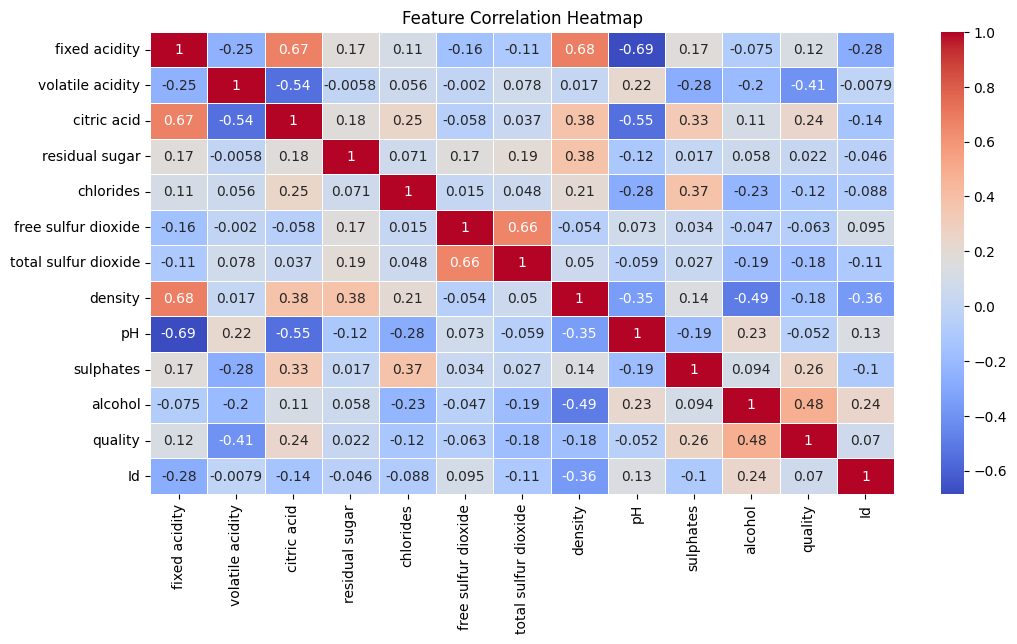

In [11]:
# Compute correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

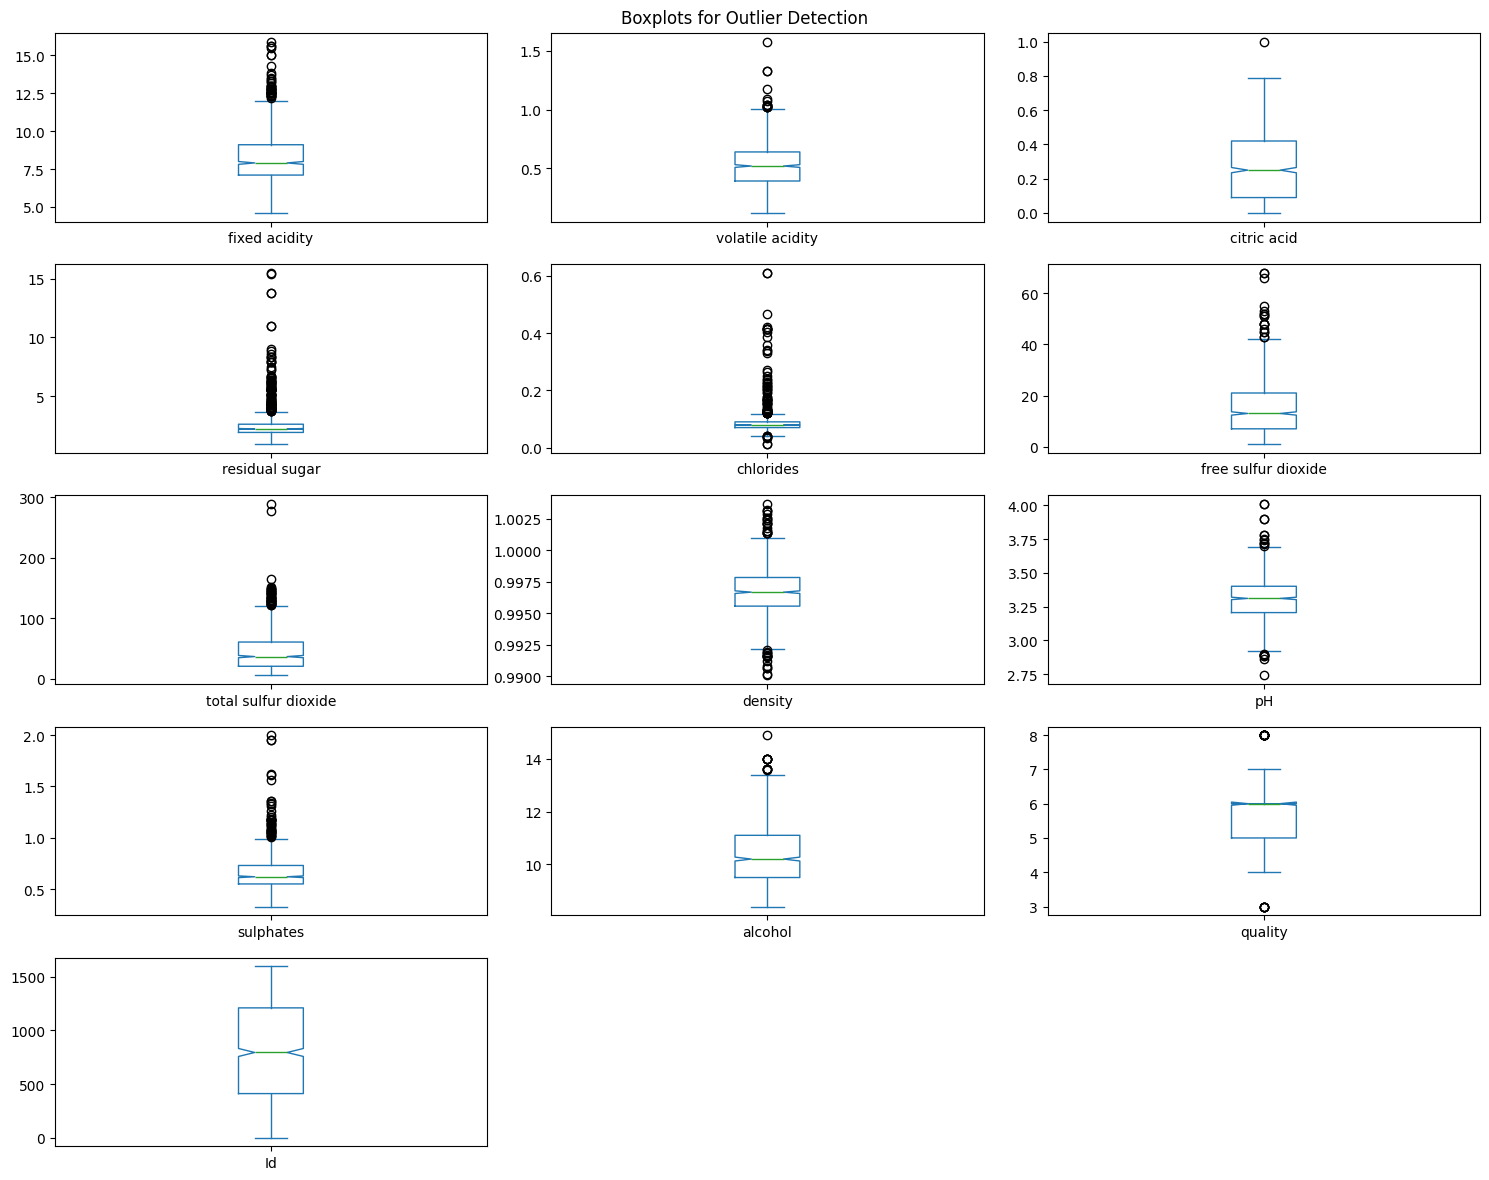

In [13]:
# Plot boxplots for each feature, adjusting the layout to fit all 13 features
df.plot(kind='box', subplots=True, layout=(5, 3), figsize=(15, 12), notch=True) # Increased rows to 5 to fit 13 subplots
plt.suptitle("Boxplots for Outlier Detection")
plt.tight_layout()  # Adjust subplot parameters for a tight layout to avoid overlapping
plt.show()

In [14]:
df['quality'].value_counts(normalize=True) * 100  # Percentage distribution

,proportion
quality,
5,42.257218
6,40.419948
7,12.510936
4,2.887139
8,1.399825
3,0.524934


In [15]:
from imblearn.over_sampling import SMOTE

# Separate features & target
X = df.drop(columns=['quality'])
y = df['quality']

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame
df = pd.DataFrame(X_resampled, columns=X.columns)
df['quality'] = y_resampled

print("Data after SMOTE:\n", df['quality'].value_counts())

Data after SMOTE:
 quality
5    483
6    483
7    483
4    483
8    483
3    483
Name: count, dtype: int64


In [16]:
# Function to remove outliers using IQR
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_cleaned = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_cleaned

# Apply outlier removal
df = remove_outliers(df)

print("Dataset size after removing outliers:", df.shape)

Dataset size after removing outliers: (2024, 13)


In [17]:
from sklearn.feature_selection import mutual_info_classif

# Compute Mutual Information
X = df.drop(columns=['quality'])
y = df['quality']
mi = mutual_info_classif(X, y, random_state=42)

# Convert to DataFrame
mi_scores = pd.DataFrame({'Feature': X.columns, 'MI Score': mi})
mi_scores = mi_scores.sort_values(by="MI Score", ascending=False)

print(mi_scores)

                 Feature  MI Score
9              sulphates  0.721442
10               alcohol  0.715565
1       volatile acidity  0.576232
2            citric acid  0.539554
11                    Id  0.528852
8                     pH  0.485820
5    free sulfur dioxide  0.456376
4              chlorides  0.446379
6   total sulfur dioxide  0.438327
3         residual sugar  0.415882
0          fixed acidity  0.415069
7                density  0.297433


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [22]:
!pip install catboost

In [24]:
# Necessary imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tqdm import tqdm  # Progress bar for model training

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Map the target variable to sequential values (Important for XGBClassifier)
quality_mapping = {3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5}
y_train = y_train.map(quality_mapping)
y_test = y_test.map(quality_mapping)

# Dictionary of models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "Decision Tree": RandomForestClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "SVM": SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

# Train and evaluate models
accuracy_scores = {}
f1_scores = {}

print("\n🔄 Training models...\n")
for name, model in tqdm(models.items()):  # Progress bar added
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_scores[name] = acc
    f1_scores[name] = f1

    print(f"{name}: Accuracy = {acc:.4f}, F1-score = {f1:.4f}")

# Print accuracy & F1-score of all models
print("\n📊 **Model Performance Comparison:**\n")
for model in models.keys():
    print(f"{model}: Accuracy = {accuracy_scores[model]:.4f}, F1-score = {f1_scores[model]:.4f}")

# Display Classification Report for Best Model
best_model = max(accuracy_scores, key=accuracy_scores.get)
print(f"\n🏆 **Best Model: {best_model}**")
print(classification_report(y_test, models[best_model].predict(X_test)))


🔄 Training models...



 12%|█▎        | 1/8 [00:00<00:00,  9.82it/s]

Logistic Regression: Accuracy = 0.6148, F1-score = 0.6052


 25%|██▌       | 2/8 [00:01<00:05,  1.10it/s]

Decision Tree: Accuracy = 0.8420, F1-score = 0.8366


 38%|███▊      | 3/8 [00:03<00:06,  1.35s/it]

Random Forest: Accuracy = 0.8370, F1-score = 0.8332


 50%|█████     | 4/8 [00:03<00:03,  1.09it/s]

SVM: Accuracy = 0.8074, F1-score = 0.7974
KNN: Accuracy = 0.7457, F1-score = 0.7204


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
 75%|███████▌  | 6/8 [00:04<00:01,  1.42it/s]

XGBoost: Accuracy = 0.8444, F1-score = 0.8424
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 1619, number of used features: 12
[LightGBM] [Info] Start training from score -2.081296
[LightGBM] [Info] Start training from score -1.776436
[LightGBM] [Info] Start training from score -1.806068
[LightGBM] [Info] Start training from score -1.682454
[LightGBM] [Info] Start training from score -1.761943
[LightGBM] [Info] Start training from score -1.692470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

 88%|████████▊ | 7/8 [00:05<00:00,  1.26it/s]

LightGBM: Accuracy = 0.8543, F1-score = 0.8533


100%|██████████| 8/8 [00:21<00:00,  2.66s/it]

CatBoost: Accuracy = 0.8593, F1-score = 0.8572

📊 **Model Performance Comparison:**

Logistic Regression: Accuracy = 0.6148, F1-score = 0.6052
Decision Tree: Accuracy = 0.8420, F1-score = 0.8366
Random Forest: Accuracy = 0.8370, F1-score = 0.8332
SVM: Accuracy = 0.8074, F1-score = 0.7974
KNN: Accuracy = 0.7457, F1-score = 0.7204
XGBoost: Accuracy = 0.8444, F1-score = 0.8424
LightGBM: Accuracy = 0.8543, F1-score = 0.8533
CatBoost: Accuracy = 0.8593, F1-score = 0.8572

🏆 **Best Model: CatBoost**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       0.90      0.96      0.93        69
           2       0.73      0.70      0.71        66
           3       0.67      0.64      0.65        75
           4       0.91      0.90      0.91        70
           5       0.96      1.00      0.98        74

    accuracy                           0.86       405
   macro avg       0.86      0.87      0.86       405
weighted avg 